# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.
Наша задача исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе анализа мы должны ответить на ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
-- для одной выборки;
-- для двух выборок;
-- для нескольких выборок;
- тест для категориальных признаков.

Источник датасета: ["“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)


## Загрузка данных

In [623]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.contingency_tables import mcnemar

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2")


In [624]:
#загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [625]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [626]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [627]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))


Количество дубликатов: 0


Проверим данные на наличие неинформативных признаков

Признак "Unnamed: 0" повторяет индекс, поэтому его можно убрать. Признак "salary" отображает величину зарплаты в разных валютах, и, можно сказать, повторяет признак "salary_in_usd". Поэтому оставим признак "salary_in_usd" отображающий величину зарплаты в USD, а признаки "salary" и "salary_currency" удалим.

In [628]:
data = data.drop(['Unnamed: 0','salary','salary_currency'],axis=1)


Общее распределение зарплат в USD в сфере Data Science за 2020–2022

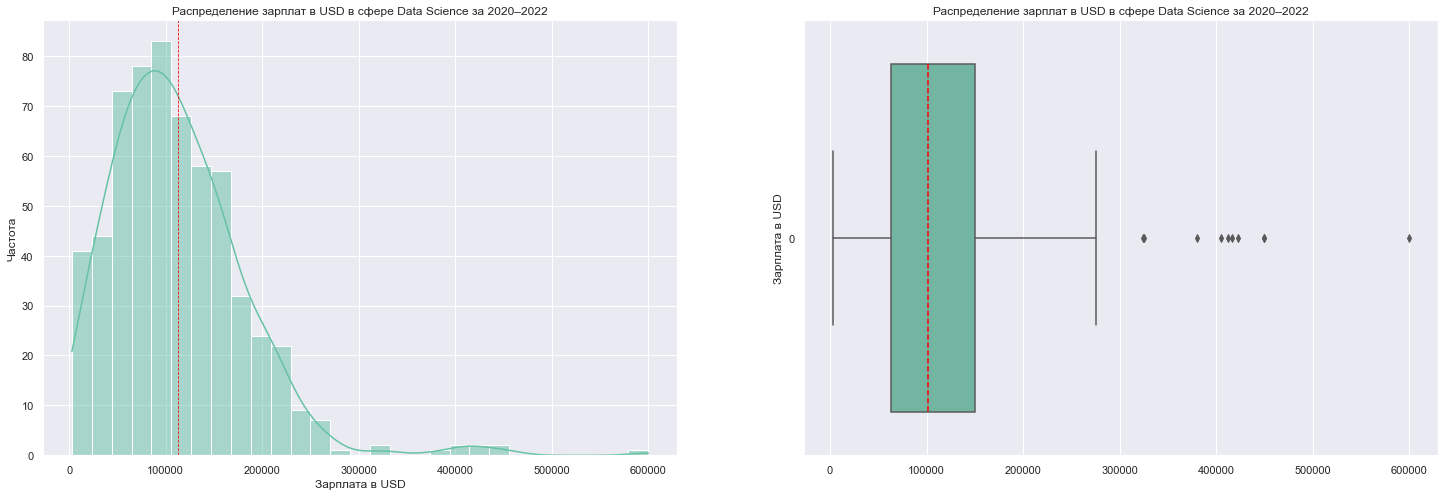

In [629]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в USD')
axes[1].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')

plt.show()

In [630]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Зарплата в USD']
data_agg

,Зарплата в USD
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Распеределение зарплат в USD отлично от нормального, имеются выбросы.

### Распределение зарплат для специалистов Data Sicentist

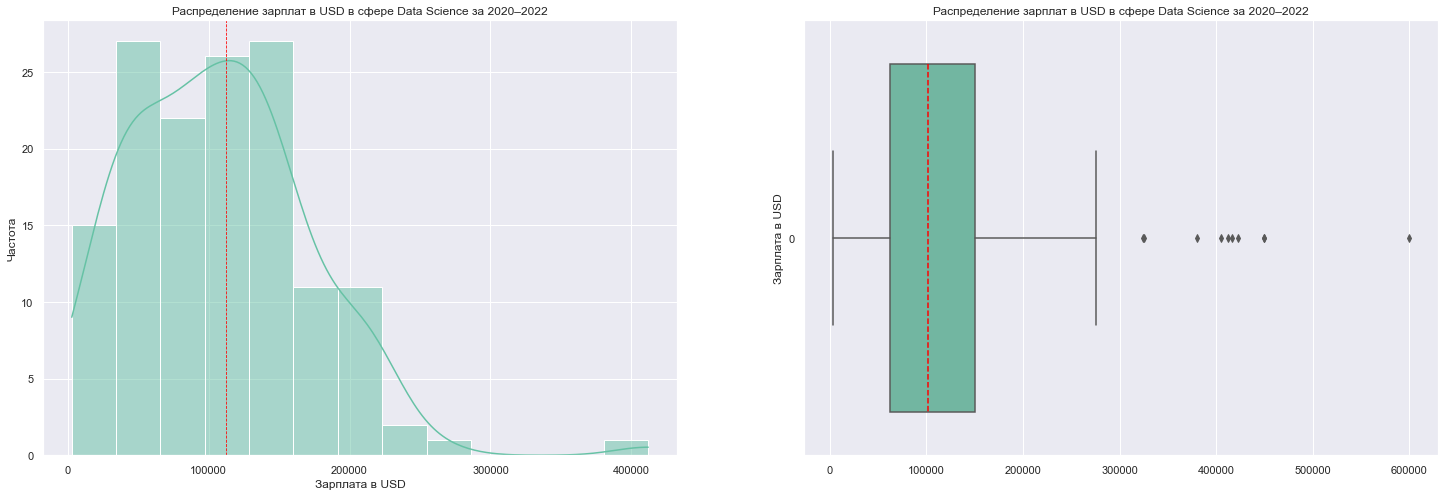

In [631]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.histplot(data[data['job_title']=='Data Scientist']['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в USD')
axes[1].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')

plt.show()

In [632]:
data_agg = data[data['job_title']=='Data Scientist']['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Зарплата в USD']
data_agg

,Зарплата в USD
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


Распеределение зарплат для специалистов Data Scientist отлично от нормального, имеются выбросы.

### Зарплата в USD в зависимости от года

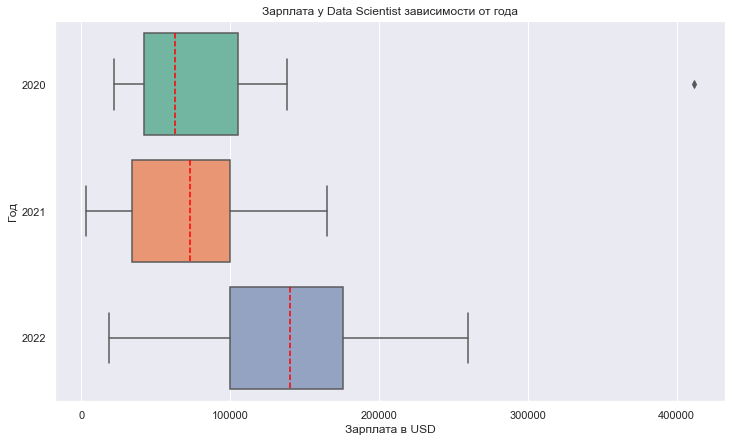

In [633]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Год')
plt.title('Зарплата у Data Scientist зависимости от года')
plt.show()

In [634]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('work_year')['salary_in_usd'].describe()
print('Зарплата в USD в зависимости от года')
data_agg

Зарплата в USD в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.523810,81436.648711,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.733333,45422.967568,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.090909,54563.084740,18442.0,100000.0,140000.0,176000.0,260000.0


Из полученных данных видно, что медианная зарплата с каждым годом повышается. Особенно видно различие между 2021 и 2022 годом. Так же видно, что количество вакансий с каждым годом существенно увеличивается. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Факторы влияющие на зарплату у специалистов Data Scientist

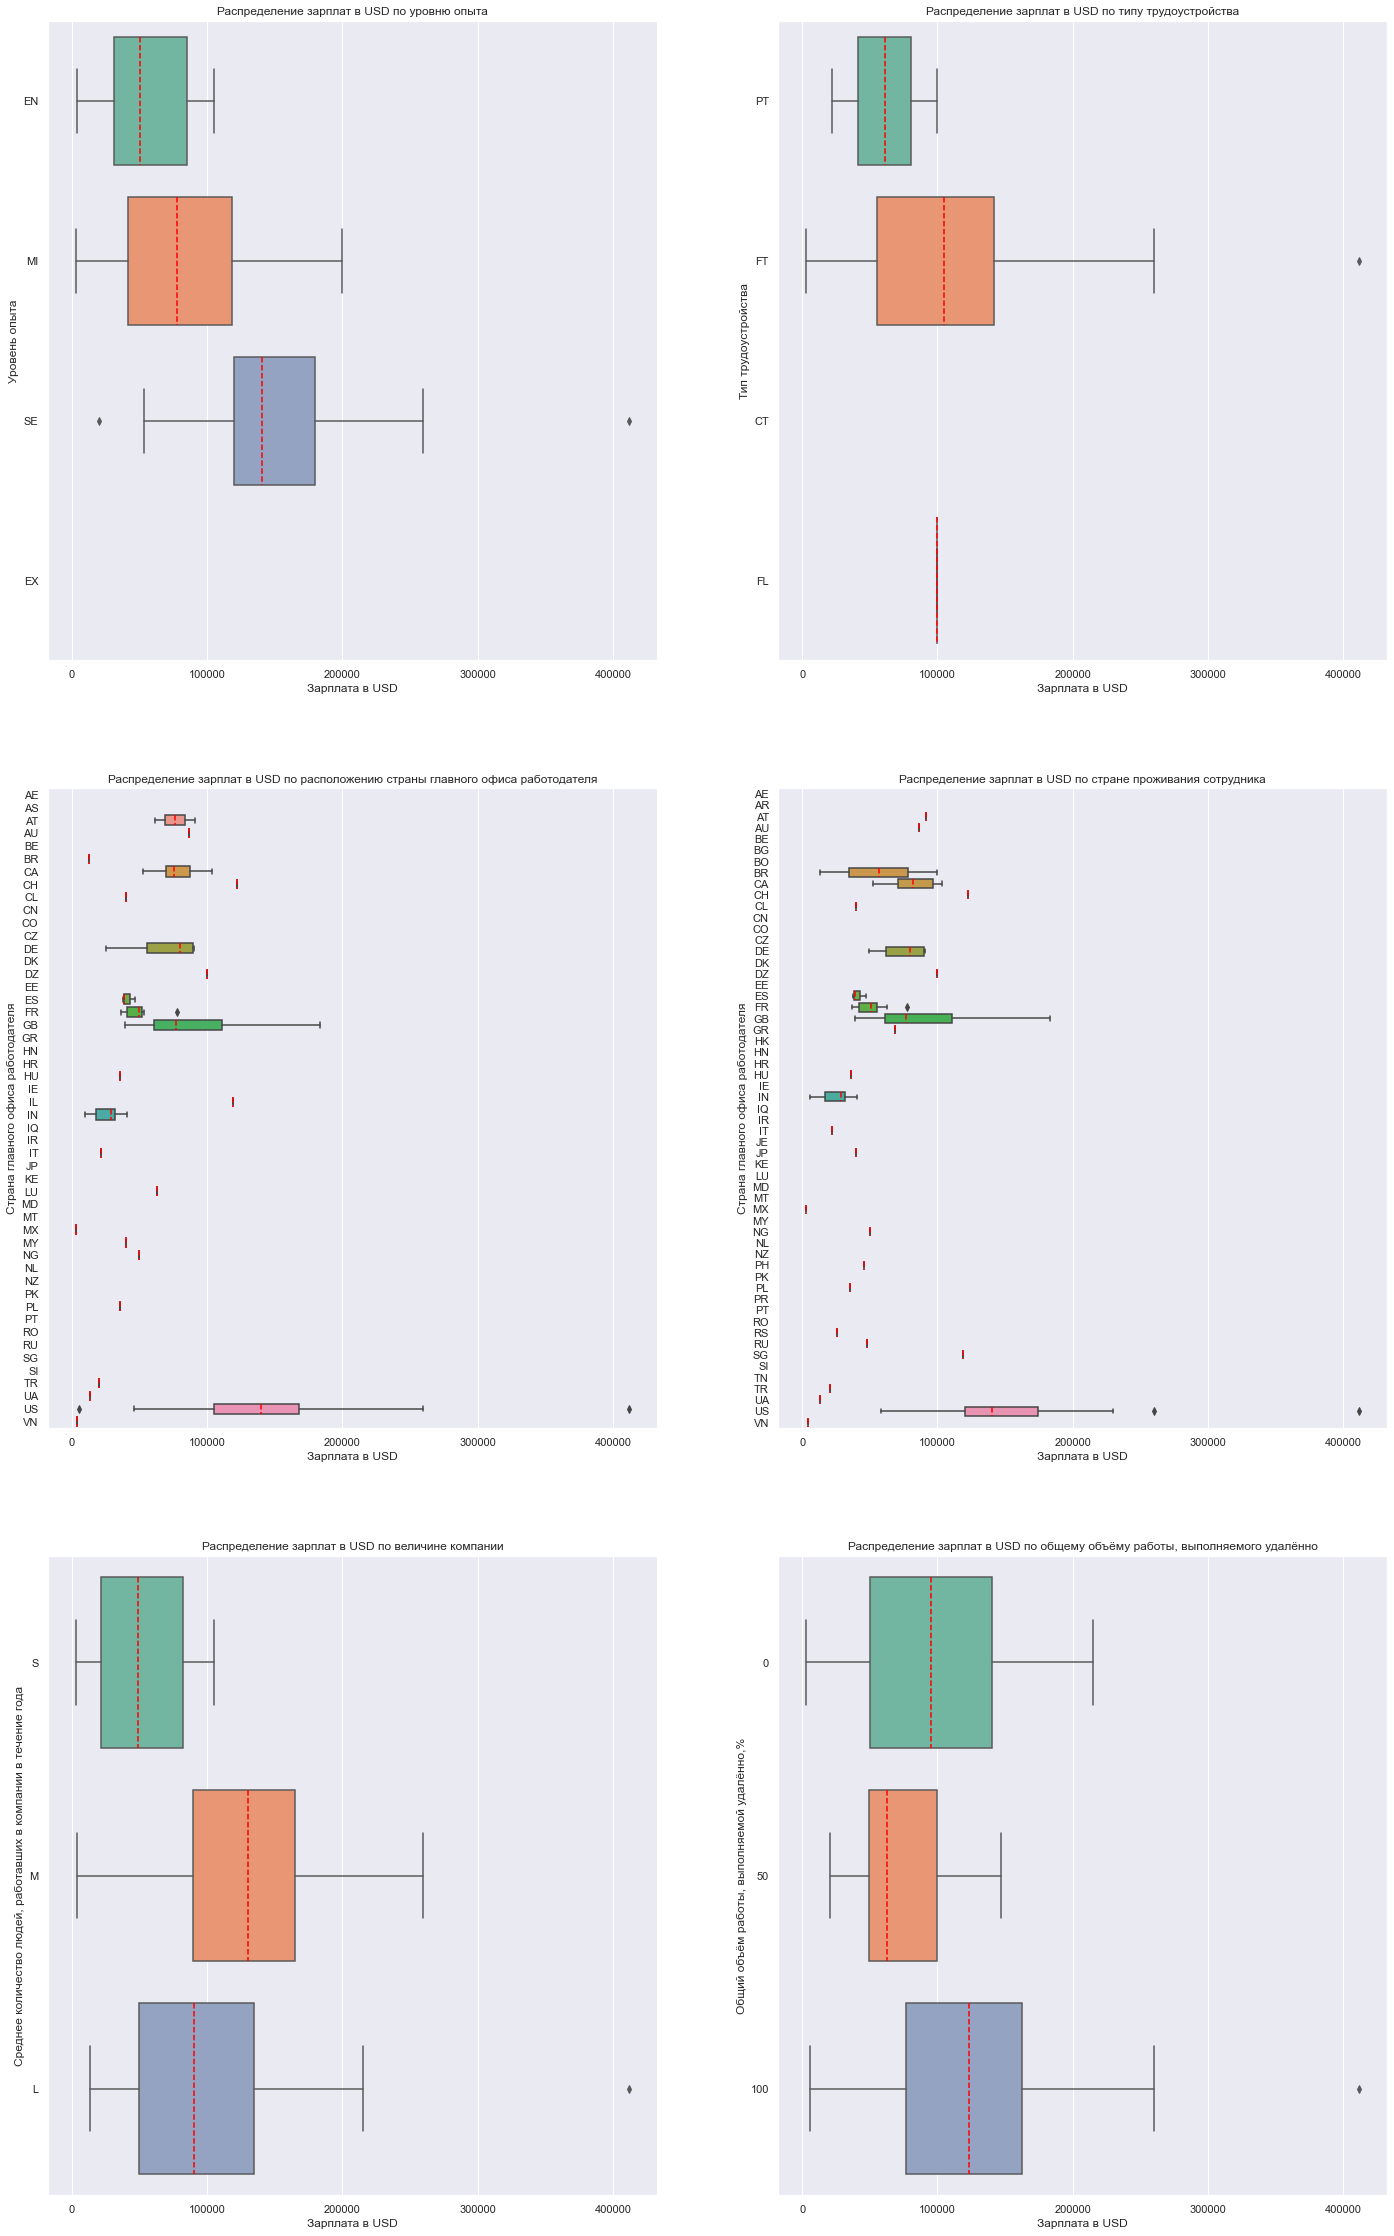

In [635]:
fig, axes = plt.subplots(3, 2, figsize=(24, 40))

sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='experience_level',  ax=axes[0, 0], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['EN', 'MI', 'SE', 'EX'])
axes[0, 0].set(xlabel='Зарплата в USD', ylabel='Уровень опыта')
axes[0, 0].set_title('Распределение зарплат в USD по уровню опыта')


sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='employment_type', ax=axes[0, 1], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['PT', 'FT', 'CT', 'FL'])
axes[0, 1].set(xlabel='Зарплата в USD', ylabel='Тип трудоустройства')
axes[0, 1].set_title('Распределение зарплат в USD по типу трудоустройства')


sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='company_location', ax=axes[1, 0], orient='h', medianprops={"color": "red", "linestyle": '--'}, order=sorted(data['company_location'].unique()))
axes[1, 0].set(xlabel='Зарплата в USD', ylabel='Страна главного офиса работодателя')
axes[1, 0].set_title('Распределение зарплат в USD по расположению страны главного офиса работодателя')

sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='employee_residence', ax=axes[1, 1], orient='h', medianprops={"color": "red", "linestyle": '--'}, order=sorted(data['employee_residence'].unique()))
axes[1, 1].set(xlabel='Зарплата в USD', ylabel='Страна главного офиса работодателя')
axes[1, 1].set_title('Распределение зарплат в USD по стране проживания сотрудника')

sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='company_size', ax=axes[2, 0], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['S', 'M', 'L'])
axes[2, 0].set(xlabel='Зарплата в USD', ylabel='Среднее количество людей, работавших в компании в течение года')
axes[2, 0].set_title('Распределение зарплат в USD по величине компании')

sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='remote_ratio', ax=axes[2, 1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[2, 1].set(xlabel='Зарплата в USD', ylabel='Общий объём работы, выполняемой удалённо,%')
axes[2, 1].set_title('Распределение зарплат в USD по общему объёму работы, выполняемого удалённо')





plt.show()


In [636]:
custom_order = ['EN', 'MI', 'SE', 'EX']

# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('experience_level')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от уровня опыта')
data_agg

Зарплата в USD  зависимости от уровня опыта


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.909091,31237.823453,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.133333,46869.579661,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.016393,58985.402166,20171.0,120000.0,140400.0,180000.00,412000.0
EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Чем выше уровень опыта, тем выше ЗП. Уровень опыта влияет на зарплату у специалистов Data Scientist.

In [637]:
custom_order = ['PT', 'FT', 'CT', 'FL']

# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('employment_type')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от типа трудоустройства')
data_agg

Зарплата в USD  зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
PT,2.0,60834.500000,55388.381277,21669.0,41251.75,60834.5,80417.25,100000.0
FT,140.0,108922.792857,64372.431676,2859.0,55490.00,104796.0,141975.00,412000.0
CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FL,1.0,100000.000000,NaN,100000.0,100000.00,100000.0,100000.00,100000.0


Данных для анализа зарплаты относительно типа трудоуйстройства слишком мало, чтобы провести сравнение.

In [638]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('company_location')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от страны главного офиса работодателя')
data_agg

Зарплата в USD в зависимости от страны главного офиса работодателя


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.000000,21050.568876,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.000000,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.000000,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.000000,19301.645448,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.000000,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.000000,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,7.0,69640.142857,25045.560355,25532.0,55997.0,79833.0,89694.00,90734.0
DZ,1.0,100000.000000,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.666667,4935.344399,37825.0,38300.5,38776.0,42792.50,46809.0


Судя по данным распределение зарплат относительно стран различно. Страна главного офиса работодателя влияет на зарплату у специалистов Data Scientist.

In [639]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('employee_residence')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от страны проживания сотрудника')
data_agg

Зарплата в USD в зависимости от страны проживания сотрудника


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AT,1.0,91237.000000,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
AU,1.0,86703.000000,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.500000,61588.293535,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.166667,19500.744646,52396.0,70945.50,81756.0,96934.50,103691.0
CH,1.0,122346.000000,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CL,1.0,40038.000000,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
DE,7.0,74773.714286,16834.872881,49268.0,62096.50,79833.0,89694.00,90734.0
DZ,1.0,100000.000000,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
ES,3.0,41136.666667,4935.344399,37825.0,38300.50,38776.0,42792.50,46809.0


Распределение зарплат относительно стран проживания различно. Страна проживания влияет на зарплату у специалистов Data Scientist. 

In [640]:
custom_order = ['S', 'M', 'L']

# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('company_size')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от величины компании')
data_agg

Зарплата в USD  зависимости от величины компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
S,21.0,51925.761905,33216.289638,2859.0,21669.0,49268.0,82500.0,105000.0
M,77.0,126380.753247,56389.528710,4000.0,90000.0,130000.0,165000.0,260000.0
L,45.0,103313.355556,71815.176484,13400.0,50000.0,90734.0,135000.0,412000.0


Распределение зарплат относительно величины компании различно. Величина компании влияет на зарплату у специалистов Data Scientist.

In [641]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data[data['job_title']=='Data Scientist'].groupby('remote_ratio')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от общего объёма работы, выполняемого удалённо в %')
data_agg

Зарплата в USD в зависимости от общего объёма работы, выполняемого удалённо в %


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.743590,58259.423987,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.080000,35602.824979,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.936709,69370.994779,5679.0,76366.0,123000.0,162500.0,412000.0


Распределение зарплат относительно процента выполняемой удаленно работы различно. Процента выполняемой удаленно работы влияет на зарплату у специалистов Data Scientist.

### Была ли зарплата специалистов Data Scientist больше, чем запрплата специлистов Data Engineer в 2022 году?

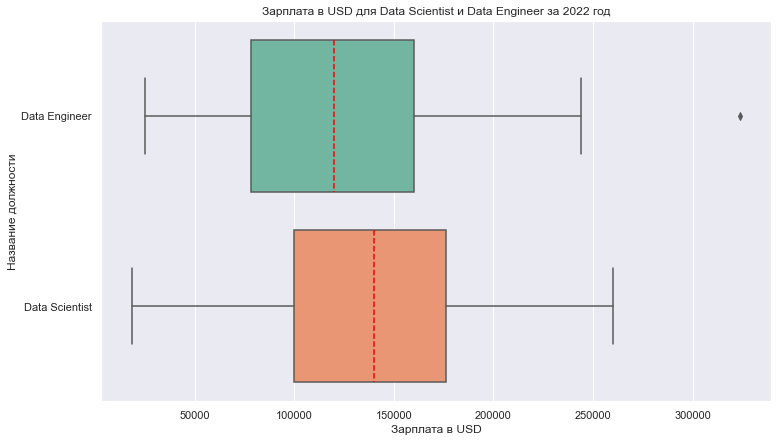

In [642]:
# строим график для зарплат Data Scientist и Data Engineer за 2022 год
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data[data['job_title'].isin(['Data Scientist', 'Data Engineer']) & data['work_year'].isin([2022])], x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Название должности')
plt.title('Зарплата в USD для Data Scientist и Data Engineer за 2022 год')
plt.show()


In [643]:
data[data['job_title'].isin(['Data Scientist', 'Data Engineer']) & data['work_year'].isin([2022])].groupby('job_title')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.696629,55954.398677,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.090909,54563.084740,18442.0,100000.0,140000.0,176000.0,260000.0


Судя по данным зарплаты для Data Scientist чуть больше зарплаты Data Engineer за 2022 год. Чтобы определить, так ли это, в следующем разделе мы проведём статистические тесты.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

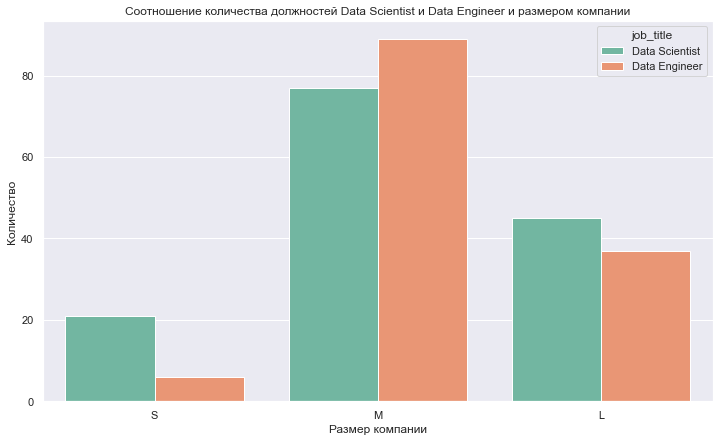

In [644]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data=data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])], x='company_size', hue='job_title',order=['S','M','L'])
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение количества должностей Data Scientist и Data Engineer и размером компании')
plt.show()

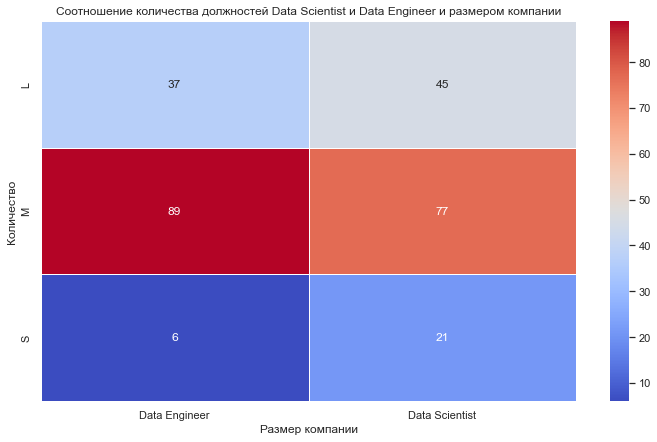

In [645]:
plt.figure(figsize=(12, 7))
cross_tab = pd.crosstab(index=data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]['company_size'], columns=data['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение количества должностей Data Scientist и Data Engineer и размером компании')
plt.show()

Судя по полученным данным различия между наличием должностей Data Scientist и Data Engineer и размером компании неоднозначны. В маленьких компаниях должность Data Engineer встречается реже, чем  Data Scientist. В средних наоборот Data Engineer встречается чаще. А в крпуных опять чуть реже. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Дополнительный вопрос #1:

### Размер заработной платы у специалистов Data Scientist уровня опыта EN, работающих удаленно больше 40000 USD?

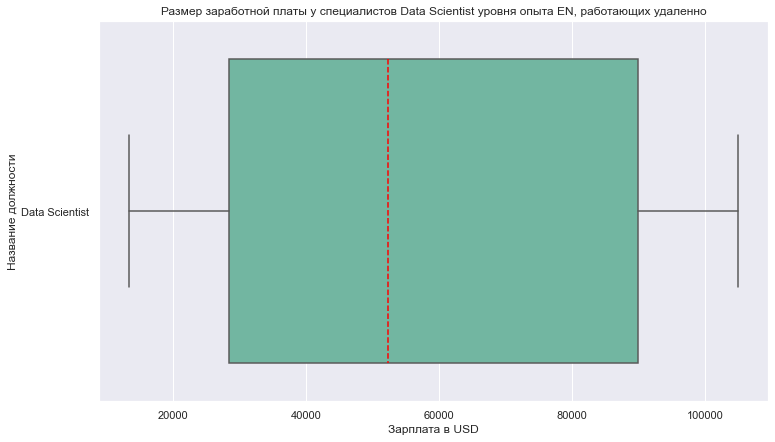

In [646]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data[data['job_title'].isin(['Data Scientist']) & data['remote_ratio'].isin([100]) & data['experience_level'].isin(['EN'])], x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Название должности')
plt.title('Размер заработной платы у специалистов Data Scientist уровня опыта EN, работающих удаленно')
plt.show()

In [647]:
data_agg = data[data['job_title'].isin(['Data Scientist']) & data['remote_ratio'].isin([100]) & data['experience_level'].isin(['EN'])].groupby('job_title')['salary_in_usd'].describe()

# Выводим результат
print('Размер заработной платы у специалистов Data Scientist уровня опыта EN, работающих удаленно')
data_agg

Размер заработной платы у специалистов Data Scientist уровня опыта EN, работающих удаленно


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Scientist,9.0,58626.333333,35817.399298,13400.0,28399.0,52396.0,90000.0,105000.0


Судя по данным зарплата удаленщиков Data Scientist уровня EN больше 40000 USD. Чтобы определить, так ли это, в следующем разделе мы проведём статистические тесты.

### Дополнительный вопрос #2:

### Есть ли связь между величиной компании и зарплатой для специалистов сферы Data Science уровня EN?

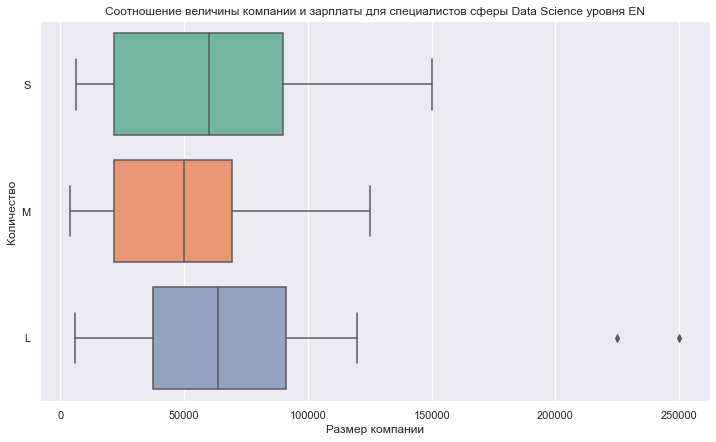

In [648]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data=data[data['experience_level'].isin(['EN'])], x='salary_in_usd', y='company_size',order=['S','M','L'])
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение величины компании и зарплаты для специалистов сферы Data Science уровня EN')
plt.show()

In [649]:
data_agg = data[data['experience_level'].isin(['EN'])].groupby('company_size')['salary_in_usd'].describe()

# Выводим результат
print('Размер заработной платы специалистов сферы Data Science уровня опыта EN в зависимости от величины компании')
data_agg

Размер заработной платы специалистов сферы Data Science уровня опыта EN в зависимости от величины компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,29.0,72813.241379,54824.561015,5882.0,37300.00,63831.0,91000.0,250000.0
M,30.0,50321.800000,33975.409445,4000.0,21688.75,49823.0,69250.0,125000.0
S,29.0,62185.310345,40693.000927,6072.0,21669.00,60000.0,90000.0,150000.0


Судя по данным зарплаты различаются в зависимости от величины компании для специалистов сферы Data Science уровня EN. Чтобы определить, так ли это, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных




In [650]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сначала сравним 2020 и 2021 год**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты за 2021 ($μ_1$) статистически меньше либо равен размеру зарплаты за 2020($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$):  размер зарплаты за 2021 ($μ_1$) статистически больше размера зарплаты за 2020($μ_2$)

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [651]:
# значения страховых выплат
salary_2020 = data[data['job_title']=='Data Scientist'].loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = data[data['job_title']=='Data Scientist'].loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = data[data['job_title']=='Data Scientist'].loc[data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [652]:

_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')
decision_hypothesis(p)


p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Теперь сравним 2021 и 2022 год**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты за 2022 ($μ_1$) статистически меньше либо равен размеру зарплаты за 2021($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$):  размер зарплаты за 2022 ($μ_1$) статистически больше размера зарплаты за 2021($μ_2$)

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий.

**Проведём тест**

In [653]:

# проведем такой же тест для 2021 года и 2022 года
_, p = stats.ttest_ind(salary_2022, salary_2021, alternative='greater', equal_var=True)

print('Тест на равенство дисперсий')
result = stats.levene(salary_2022, salary_2021)
p = result[1]
# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
    
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_2022, salary_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)

Тест на равенство дисперсий
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

С 2020 по 2021 размер зарплат у специалистов Data Scientist не вырос. Но с 2021 по 2022 размер зарплат увеличился.

### Была ли зарплата специалистов Data Scientist больше, чем запрплата специлистов Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплат Data Scientist ($μ_1$) меньше или равен зарплате Data Engineer ($μ_2$) в 2022 году .
$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза*: размер зарплат Data Scientist ($μ_1$) больше чем зарплата Data Engineer ($μ_2$) за 2022 год.
$$ H_1 : μ_1 > μ_2 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [654]:
# значения зарплат
ds_salary = data[data['work_year']==2022].loc[data['job_title']=='Data Scientist', 'salary_in_usd']
eng_salary = data[data['work_year']==2022].loc[data['job_title']=='Data Engineer', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Зарплата у Data Scientist:')
result = stats.shapiro(ds_salary)
decision_normality(result[1])

print('Зарплата у Data Engineer:')
result = stats.shapiro(eng_salary)
decision_normality(result[1])



Зарплата у Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата у Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd» (зарплата в долларах США)? — Количественный.
* Сколько сравниваемых групп? — 2.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий U-критерий Манна — Уитни.

**Проведём тест**

In [655]:
# проводим тест
_, p = stats.mannwhitneyu(ds_salary, eng_salary,alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Размер зарплат специалистов Data Scientist не была больше зарплат специалистов Data Engineer в 2022 году.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь(признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «job_titlee» (название должности)? — Категориальный.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [656]:
# составляем таблицу сопряжённости
table = pd.crosstab(data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]['job_title'],data['company_size'] )

display(table)
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

decision_hypothesis(p)

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Сущесвтует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

### Дополнилеьные вопросы:

### Размер заработной платы у специалистов Data Scientist уровня опыта EN, работающих удаленно больше 40000 USD?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Размер заработной платы у специалистов Data Scientist  уровня опыта EN ($μ_1$) меньше или равен 40000 
$$ H_0 : μ_1 <= 40000 $$

*Альтернативная гипотеза*: Размер заработной платы у специалистов Data Scientist  уровня опыта EN ($μ_1$) больше 40000 
$$ H_1 : μ_1 > 40000 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [657]:
# значения зарплат
ds_en_salary = data[data['remote_ratio'].isin([100]) & data['experience_level'].isin(['EN'])].loc[data['job_title']=='Data Scientist', 'salary_in_usd']



# проводим тест Шапиро-Уилка
print('Зарплата у Data Scientist:')
result = stats.shapiro(ds_en_salary)
decision_normality(result[1])



Зарплата у Data Scientist:
p-value = 0.283
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd» (зарплата в долларах США)? — Количественный.
* Сколько сравниваемых групп? — 1.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий.

**Проведём тест**

In [658]:
# проводим тест
_, p = stats.ttest_1samp(ds_en_salary, popmean=40000, alternative='greater')
decision_hypothesis(p)


p-value = 0.079
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что заработная плата для специалистов сферы Data Scientist уровня опыта EN, работающих удаленно больше 40000 USD.

### Есть ли связь между величиной компании и зарплатой для специалистов сферы Data Science уровня EN?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы для специалистов уровня EN не отличиается в зависимости от величины компании : S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы для специалистов уровня EN отличиается в зависимости от величины компании : S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [659]:
# значения зарплат
salary_S = data[data['experience_level'].isin(['EN'])].loc[data['company_size']=='S', 'salary_in_usd']
salary_M= data[data['experience_level'].isin(['EN'])].loc[data['company_size']=='M', 'salary_in_usd']
salary_L = data[data['experience_level'].isin(['EN'])].loc[data['company_size']=='L', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_L)
decision_normality(result[1])



Для S:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.122
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd» (зарплата в долларах США)? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [660]:
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.227
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что заработная плата для специалистов сферы Data Science уровня EN различается в зависимости от величины компании.

## Итоговые результаты исследования

*   Каждый год рост зарплат специалистов Data Scientist не наблюдается. С 2020 по 2021 размер зарплат не вырос. Но с 2021 по 2022 размер зарплат уже увеличился.
*   Факторы влияющие на уровень зарплаты:
   1) Уровень опыта. Чем выше уровень, тем выше ЗП. 
   2) Страна главного офиса работодателя или филиала по контракту.
   3) Основная страна проживания сотрудника в течение рабочего года
   4) Общий объём работы, выполняемой удалённо
   5) Величина компании.
*   Размер зарплат специалистов Data Scientist не была больше зарплат специалистов Data Engineer в 2022 году.
*   Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.
*   Нет оснований утверждать, что заработная плата для специалистов сферы Data Scientist уровня опыта EN, работающих удаленно больше 40000 USD.
*   Размер компании не влияет на величину зарплаты для специалистов сферы Data Science уровня опыта EN.